In [1]:


import numpy as np 
import pandas as pd 
import os


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Train Inseption-ResNet-V2

In [3]:
df = pd.read_csv('../input/k/aslanahmedov/automatic-number-plate-recognition/labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/number-plate-detection/images/N148.xml,244,369,240,293
1,../input/number-plate-detection/images/N177.xml,331,538,263,317
2,../input/number-plate-detection/images/N173.xml,80,335,150,243
3,../input/number-plate-detection/images/N213.xml,131,209,129,153
4,../input/number-plate-detection/images/N119.xml,180,559,216,314


In [4]:
dtrain = os.listdir('../input/k/aslanahmedov/automatic-number-plate-recognition/yolov5/data_images/train')
dtest = os.listdir('../input/k/aslanahmedov/automatic-number-plate-recognition/yolov5/data_images/test')

In [5]:
TRAIN_PATH = '../input/k/aslanahmedov/automatic-number-plate-recognition/yolov5/data_images/train'
TEST_PATH = '../input/k/aslanahmedov/automatic-number-plate-recognition/yolov5/data_images/test'

In [6]:
len(dtrain)

400

In [7]:
img_path = []
txt_path = []
for x in range(len(dtrain)):
    if dtrain[x].endswith('.jpeg'):
        suf = dtrain[x][:-5]
        img_path.append(dtrain[x])
        txt_path.append(suf + '.txt')

In [8]:
img_test_path = []
txt_test_path = []
for x in range(len(dtest)):
    if dtest[x].endswith('.jpeg'):
        suf = dtest[x][:-5]
        img_test_path.append(dtest[x])
        txt_test_path.append(suf + '.txt')

In [9]:
data = []
output = []
for i in range(len(img_path)):
    image = os.path.join(TRAIN_PATH, img_path[i])
    img_arr = cv2.imread(image)
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    lab = img_path[i][:-5]
    with open(os.path.join(TRAIN_PATH, lab+'.txt'), 'r') as file:
        doc = file.read()
        file.close()
    cases = doc.split('\n')
    box = []
    for case in cases:
        nxmin,nxmax,nymin,nymax = case.split(' ')[1:]
        label_norm = (float(nxmin),float(nxmax),float(nymin),float(nymax))
        box.append(label_norm)
    data.append(norm_load_image_arr)
    output.append(box)

In [10]:
data_test = []
output_test = []
for i in range(len(img_test_path)):
    image = os.path.join(TEST_PATH, img_test_path[i])
    img_arr = cv2.imread(image)
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    lab = img_test_path[i][:-5]
    with open(os.path.join(TEST_PATH, lab+'.txt'), 'r') as file:
        doc = file.read()
        file.close()
    cases = doc.split('\n') 
    box = []
    for case in cases:
        nxmin,nxmax,nymin,nymax = case.split(' ')[1:]
        label_norm = (float(nxmin),float(nxmax),float(nymin),float(nymax))
        box.append(label_norm)
    data_test.append(norm_load_image_arr)
    output_test.append(box)

In [11]:
x_train,x_test,y_train,y_test = np.array(data,dtype=np.float32), np.array(data_test,dtype=np.float32), np.array(output,dtype=np.float32), np.array(output_test,dtype=np.float32)

In [12]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

2022-11-01 18:44:17.211766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:44:17.306276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:44:17.307016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:44:17.308188: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 1s 0us/step


In [13]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [14]:
history = model.fit(x=x_train,y=y_train,batch_size=20,epochs=20,
                    validation_data=(x_test,y_test))

2022-11-01 18:44:25.742280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-01 18:44:42.694484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 29s 620ms/step - loss: 0.0525 - accuracy: 0.5757 - val_loss: 0.0324 - val_accuracy: 0.4706
Epoch 2/20
10/10 [==============================] - 3s 264ms/step - loss: 0.0324 - accuracy: 0.5867 - val_loss: 0.0226 - val_accuracy: 0.5859
Epoch 3/20
10/10 [==============================] - 3s 264ms/step - loss: 0.0278 - accuracy: 0.5605 - val_loss: 0.0175 - val_accuracy: 0.7059
Epoch 4/20
10/10 [==============================] - 3s 284ms/step - loss: 0.0264 - accuracy: 0.6110 - val_loss: 0.0168 - val_accuracy: 0.7059
Epoch 5/20
10/10 [==============================] - 3s 265ms/step - loss: 0.0228 - accuracy: 0.6672 - val_loss: 0.0184 - val_accuracy: 0.7059
Epoch 6/20
10/10 [==============================] - 3s 264ms/step - loss: 0.0209 - accuracy: 0.6790 - val_loss: 0.0180 - val_accuracy: 0.7059
Epoch 7/20
10/10 [==============================] - 3s 261ms/step - loss: 0.0197 - accuracy: 0.6750 - val_loss: 0.0159 - val_accuracy: 0.7059
Epoch 8/20
10/10

# Metrics

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


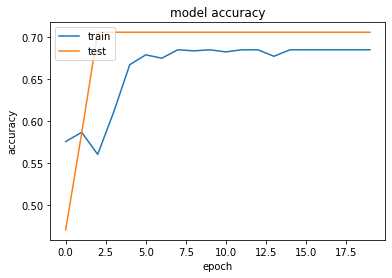

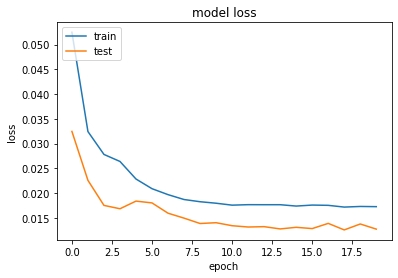

<Figure size 432x288 with 0 Axes>

In [15]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss.png')

In [16]:
model.save('inception_plate.h5')

# Train YOLOv5

In [17]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14375, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 14375 (delta 16), reused 13 (delta 6), pack-reused 14342
Receiving objects: 100% (14375/14375), 13.45 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (9921/9921), done.


In [18]:
!pip install -r ./yolov5/requirements.txt

In [19]:
os.mkdir('yolov5/data_images')
os.mkdir('yolov5/data_images/train')
os.mkdir('yolov5/data_images/test')

In [20]:
import shutil

for file_name in os.listdir(TRAIN_PATH):
    source = TRAIN_PATH + '/' + file_name
    destination = 'yolov5/data_images/train/' + file_name
    if os.path.isfile(source):
        shutil.copy(source, destination)

In [21]:
for file_name in os.listdir(TEST_PATH):
    source = TEST_PATH + '/' + file_name
    destination = 'yolov5/data_images/test/' + file_name
    if os.path.isfile(source):
        shutil.copy(source, destination)

In [22]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=a04ec4e958b85d7d7f32d1cd5ffa3a44225e9c81f5147c1c369d70c6854e334b
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [23]:
!python ./yolov5/train.py --data ../input/yamlsecond/data1.yaml --cfg ./yolov5/models/yolov5s.yaml --workers 0 --batch-size 8 --name Model --epochs 100

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=../input/yamlsecond/data1.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-224-g82a5585 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16G

In [24]:
!python ./yolov5/val.py --data ../input/yamlsecond/data1.yaml --weight ./yolov5/runs/train/Model/weights/best.pt

val: data=../input/yamlsecond/data1.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-224-g82a5585 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/kaggle/working/yolov5/data_images/test.cache' images and labels.
                 Class     Images  Instances          P          R      mAP50   
                   all         25         25      0.995          1      0.995      0.705
Speed: 0.2ms pre-process, 5.8ms inference, 1.2ms NMS per image at shape (32, 3, 640, 640)
Results saved to yolov5/runs/val/exp


In [25]:
!python ./yolov5/val.py --weight ./yolov5/runs/train/Model/weights/best.pt --data ../input/yamlsecond/data1.yaml --img 640

val: data=../input/yamlsecond/data1.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-224-g82a5585 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/kaggle/working/yolov5/data_images/test.cache' images and labels.
                 Class     Images  Instances          P          R      mAP50   
                   all         25         25      0.995          1      0.995      0.705
Speed: 0.2ms pre-process, 4.4ms inference, 1.9ms NMS per image at shape (32, 3, 640, 640)
Results saved to yolov5/runs/val/exp2


In [26]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v6.2-224-g82a5585 Python-3.7.12 torch-1.11.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.11.0...
TorchScript: export success ✅ 2.4s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success ✅ 2.8s, saved as yolov5/runs/train/Model/weights/best.onnx (27.2 MB)

Export complete (6.0s)
Results saved to /kaggle/w